In [1]:
from dataset import TrainDataLoader
from model import encoder_image,radar_encoder_sparse,mmde_encoder,association_decoder
from linear_attention import LoFTREncoderLayer,LocalFeatureTransformer
import torch
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt


In [2]:
image_folder = r"C:\Users\kagad\Thesis_implementation\Fusion_net\data\image"
mmde_map = r"C:\Users\kagad\Thesis_implementation\Fusion_net\data\mmde_map"
gt_path = r"C:\Users\kagad\Thesis_implementation\Fusion_net\data\gt_interp"
radar_path =  r"C:\Users\kagad\Thesis_implementation\Fusion_net\data\radar_png"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),])
transform_radar = transforms.Compose([
    transforms.ToTensor(),])

In [4]:
dataset = TrainDataLoader(image_folder,mmde_map,radar_path,gt_path,transform=transform)
train_loader = torch.utils.data.DataLoader(dataset,batch_size=1, shuffle=True,num_workers=0)
image, mmde_map,radar_img, ground_truth = next(iter(train_loader))

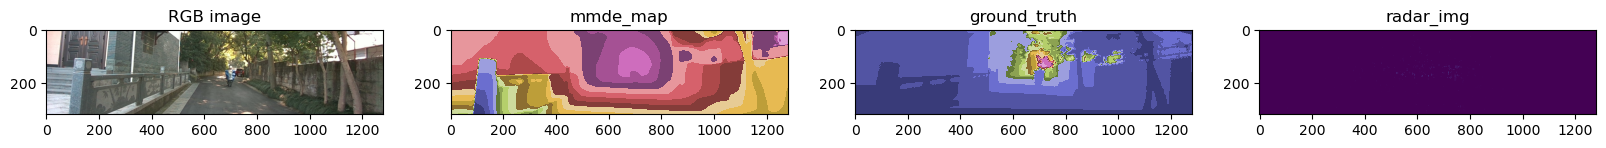

In [5]:
plt.subplots(1,4,figsize=(20,10))
plt.subplot(1,4,1)
plt.title("RGB image")
plt.imshow(image[0].permute(1,2,0))
plt.subplot(1,4,2)
plt.imshow(mmde_map[0].permute(1,2,0).squeeze(),cmap = "tab20b")
plt.title("mmde_map")
plt.subplot(1,4,3)
plt.imshow(ground_truth[0].permute(1,2,0).squeeze(),cmap = "tab20b")
plt.title("ground_truth")
plt.subplot(1,4,4)
plt.imshow(radar_img[0].permute(1,2,0).squeeze())
plt.title("radar_img")
plt.show()

In [6]:
class Params:
    def __init__(self):
        self.radar_input_channels = 1
        self.encoder_radar = 'resnet18'
        self.mmde_encoder = "resnet18"
        self.activation = 'elu' # why?
        self.encoder = 'resnet34'
        self.max_depth = 4
params = Params()

In [7]:
class fusion_net(nn.Module):
  def __init__(self,params):
    super(fusion_net, self).__init__()
    self.params = params

    self.encoder_image = encoder_image(params)
    self.encoder_radar = radar_encoder_sparse(params)
    self.mmde_encoder = mmde_encoder(params)

    self.attention = LocalFeatureTransformer(['self','cross'], n_layers=4, d_model=512)

    self.decoder = association_decoder(params,self.encoder_image.feat_out_channels, self.encoder_radar.feat_out_channels, self.mmde_encoder.feat_out_channels)

  def forward(self,image,radar_img,mmde_map):
    image_features = self.encoder_image(image)
    radar_features = self.encoder_radar(radar_img)
    mmde_features = self.mmde_encoder(mmde_map)
    radar_feature_reshape = radar_features[-1].view(radar_features[-1].shape[0],radar_features[-1].shape[1],-1).permute(0,2,1) #1*512*10*40
    image_feature_reshape = image_features[-1].view(image_features[-1].shape[0],image_features[-1].shape[1],-1).permute(0,2,1)
    latent_depth_tf, latent_image_pooled_tf = self.attention(radar_feature_reshape, image_feature_reshape)
    latent_depth_tf = latent_depth_tf.permute(0, 2, 1).view(radar_features[-1].shape)
    latent_image_pooled_tf = latent_image_pooled_tf.permute(0, 2, 1).view(image_features[-1].shape)
    radar_features[-1] = latent_depth_tf
    image_features[-1] = latent_image_pooled_tf
    depth_conf = self.decoder(image_features,radar_features,mmde_features)
    return depth_conf

In [8]:
model = fusion_net(params)

c:\Users\kagad\anaconda\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\kagad\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\kagad\anaconda\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-dat

In [9]:
depth_map = model(image,radar_img,mmde_map)

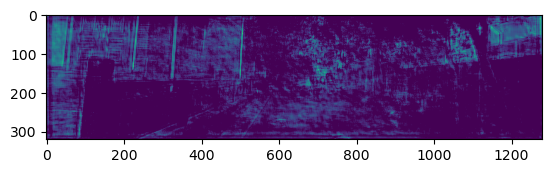

In [10]:
plt.imshow(depth_map[0,0,:,:].detach().numpy())

In [11]:
num_of_epochs = 2000
lr_rate = 0.001
momentum = 0.9
weight_decay = 0.0005

loss = nn.L1Loss	()
optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

In [12]:
for epoch in range(num_of_epochs):
    model.train()  # Ensure model is in training mode

    optimizer.zero_grad()  # Clear the gradients

    # Forward pass
    depth_map = model(image,radar_img,mmde_map)
    print("depth_map",depth_map.max())
    print("ground_truth",ground_truth.max())
    print("------------------")

    # Loss calculation
    loss_value = loss(depth_map, ground_truth)

    # Backward pass
    loss_value.backward()

    # Update parameters
    optimizer.step()

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch+1}, Loss: {loss_value.item()}")  # Use .item() to get scalar loss value

depth_map tensor(1.8868, grad_fn=<MaxBackward1>)
ground_truth tensor(96.8203)
------------------
Epoch 1, Loss: 9.355332374572754
depth_map tensor(3.4815, grad_fn=<MaxBackward1>)
ground_truth tensor(96.8203)
------------------
depth_map tensor(4.1828, grad_fn=<MaxBackward1>)
ground_truth tensor(96.8203)
------------------
depth_map tensor(4.5906, grad_fn=<MaxBackward1>)
ground_truth tensor(96.8203)
------------------
depth_map tensor(5.3140, grad_fn=<MaxBackward1>)
ground_truth tensor(96.8203)
------------------
depth_map tensor(5.8014, grad_fn=<MaxBackward1>)
ground_truth tensor(96.8203)
------------------
depth_map tensor(7.4619, grad_fn=<MaxBackward1>)
ground_truth tensor(96.8203)
------------------
depth_map tensor(8.1710, grad_fn=<MaxBackward1>)
ground_truth tensor(96.8203)
------------------
depth_map tensor(9.3231, grad_fn=<MaxBackward1>)
ground_truth tensor(96.8203)
------------------
depth_map tensor(10.9066, grad_fn=<MaxBackward1>)
ground_truth tensor(96.8203)
---------------

KeyboardInterrupt: 